In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn

In [11]:
data = pd.read_csv('./datasets/Adv.csv')
data.sample(5)

,Unnamed: 0,TV,radio,newspaper,sales
22,23,13.2,15.9,49.6,5.6
188,189,286.0,13.9,3.7,15.9
181,182,218.5,5.4,27.4,12.2
43,44,206.9,8.4,26.4,12.9
173,174,168.4,7.1,12.8,11.7


The Advertisement.csv dataset consists of the number of units of product sold in 200 different markets. Based on the advertisement budgets in each of these markets for different media channels like TV, Radio, and Newspaper, the number of sold units sales is recorded and tallied.

In [12]:
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
print(data)

        TV  radio  newspaper  sales
0    230.1   37.8       69.2   22.1
1     44.5   39.3       45.1   10.4
2     17.2   45.9       69.3    9.3
3    151.5   41.3       58.5   18.5
4    180.8   10.8       58.4   12.9
..     ...    ...        ...    ...
195   38.2    3.7       13.8    7.6
196   94.2    4.9        8.1    9.7
197  177.0    9.3        6.4   12.8
198  283.6   42.0       66.2   25.5
199  232.1    8.6        8.7   13.4

[200 rows x 4 columns]


In [13]:
data.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

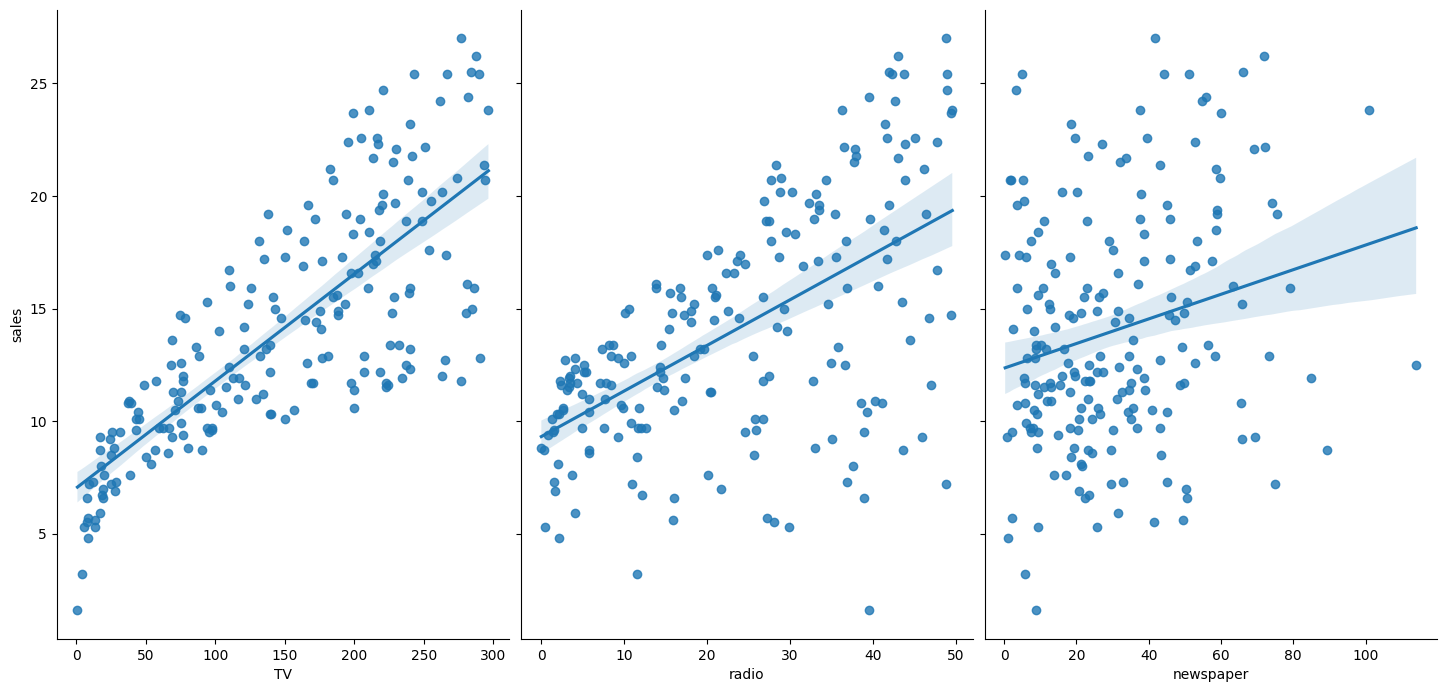

In [16]:
#plot only 3 scatterplot 'tv', 'radio' and 'newspaper' vs sales

sb.pairplot(data, x_vars = ['TV', 'radio', 'newspaper'], y_vars = 'sales', height = 7, aspect = 0.7, kind = 'reg')


In [54]:
from sklearn.model_selection import train_test_split

# X = data.drop('sales', axis = 1)
# y = data['sales']
feature_col = data.columns[:-1]
target_col = data.columns[-1]

X = data[feature_col]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [55]:
X = torch.tensor(X_train.values, dtype=torch.float32)
y = torch.tensor(y_train.values, dtype=torch.float32)

test_X = torch.tensor(X_test.values, dtype=torch.float32)
test_y = torch.tensor(y_test.values, dtype=torch.float32)
# print(test_y)
test_y.unsqueeze(1)

num_samples = X.shape[0]
num_features = X.shape[1]
num_samples, num_features

(160, 3)

In [56]:
#Scaling the training data using StandardScaler

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
X_train[:5, :]

array([[-1.07253256, -0.78312871,  0.56873594],
       [ 0.83503611,  1.66182539, -1.31173341],
       [-1.14494183, -1.44392711, -0.45397546],
       [ 0.87895648, -1.41749518, -0.7273269 ],
       [ 1.07006946, -0.47255346, -0.38328113]])

In [58]:
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [117]:
#to clear any logs from prev runs
# !rm -rf ./logs

In [60]:
## Weight Initialization
input_size = num_features
hidden_1_shape =  8
hidden_2_shape= 6
hidden_3_shape= 4
hidden_4_shape = 4
output_size = 1 

In [118]:
weights = {
    "hidden_1":torch.nn.init.trunc_normal_(torch.empty(input_size,hidden_1_shape, requires_grad=True)),
    "hidden_2":torch.nn.init.trunc_normal_(torch.empty(hidden_1_shape,hidden_2_shape, requires_grad=True)),
    "hidden_3":torch.nn.init.trunc_normal_(torch.empty(hidden_2_shape,hidden_3_shape, requires_grad=True)),
    "hidden_4":torch.nn.init.trunc_normal_(torch.empty(hidden_3_shape,hidden_4_shape, requires_grad=True)),
    "output":torch.nn.init.trunc_normal_(torch.empty(hidden_4_shape,output_size, requires_grad=True)),
    
    "hidden_1_bias": torch.nn.init.trunc_normal_(torch.empty(hidden_1_shape, requires_grad=True)),
    "hidden_2_bias": torch.nn.init.trunc_normal_(torch.empty(hidden_2_shape, requires_grad=True)),
    "hidden_3_bias": torch.nn.init.trunc_normal_(torch.empty(hidden_3_shape, requires_grad=True)),
    "hidden_4_bias": torch.nn.init.trunc_normal_(torch.empty(hidden_4_shape, requires_grad=True)),
    "output_bias": torch.nn.init.trunc_normal_(torch.empty(output_size, requires_grad=True))
}

In [119]:
torch.manual_seed(7)

In [120]:
#Forward Propagte and Activate Functions
class Model(torch.nn.Module):
    def __init__(self, weights):
        super(Model, self).__init__()
        self.weights = weights

        self.hidden_1 = torch.nn.Parameter(weights['hidden_1'])
        self.hidden_2 = torch.nn.Parameter(weights['hidden_2'])
        self.hidden_3 =  torch.nn.Parameter(weights['hidden_3'])
        self.hidden_4 =  torch.nn.Parameter(weights['hidden_4'])
        self.final_output =  torch.nn.Parameter(weights['output'])
        self.hidden_1_bias = torch.nn.Parameter(weights['hidden_1_bias'])
        self.hidden_2_bias = torch.nn.Parameter(weights['hidden_2_bias'])
        self.hidden_3_bias = torch.nn.Parameter(weights['hidden_3_bias'])
        self.hidden_4_bias = torch.nn.Parameter(weights['hidden_4_bias'])
        self.output_bias = torch.nn.Parameter(weights['output_bias'])

        self.trainable_variables = [
                                self.hidden_1,
                                self.hidden_1_bias,
                                self.hidden_2,
                                self.hidden_2_bias,
                                self.hidden_3,
                                self.hidden_3_bias,
                                self.hidden_4,
                                self.hidden_4_bias,
                                self.final_output,
                                self.output_bias
        ]   

    def forward(self, data):
        layer1 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(data, self.hidden_1), self.hidden_1_bias))
        layer2 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(layer1,self.hidden_2),self.hidden_2_bias))
        layer3 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(layer2,self.hidden_3),self.hidden_3_bias))
        layer4 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(layer3,self.hidden_4),self.hidden_4_bias))
        
        final = torch.add(torch.matmul(layer3,self.final_output),self.output_bias)

        return final
        
model = Model(weights)

In [121]:
layer1 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(X, weights['hidden_1']), weights['hidden_1_bias']))
layer2 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(layer1, weights['hidden_2']), weights['hidden_2_bias']))
layer3 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(layer2, weights['hidden_3']), weights['hidden_3_bias']))
layer4 = torch.nn.functional.leaky_relu(torch.add(torch.matmul(layer3, weights['hidden_4']), weights['hidden_4_bias']))
final = torch.add(torch.matmul(layer4, weights['output']), weights['output_bias'])

In [122]:
# Loss Function

def loss(y_pred, y):
    return torch.mean(torch.square(torch.subtract(y_pred, y)))

In [123]:
losses = loss(torch.tensor(y_train.values), y)
losses

tensor(1.4279e-13, dtype=torch.float64)

In [124]:
# optimisation Algo

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [125]:
# Define Functions for training
def train(model, inputs, outputs, learning_rate = 0.01):
    y_pred = model(inputs)
    c_loss = loss(y_pred, outputs)
    optimizer.zero_grad()
    c_loss.backward()
    optimizer.step()
    return c_loss.item()

In [126]:
X_data = X[:3]
y_data = y[:3]
train_model = train(model,X_data,y_data)

In [127]:
from torch.utils.tensorboard import SummaryWriter

In [128]:
# Run training loop
epoch = 100
batch_size = 8
lr = 0.01

training_dataset = torch.utils.data.TensorDataset(X, y)


training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size = batch_size, shuffle = True)

loss_per_epoch = []
val_loss_per_epoch = []


for i in range(epoch):
    c_loss = []
    for batch, (x_batch, y_batch) in enumerate(training_dataloader):
        c_loss.append(train(model, x_batch, y_batch, lr))


    c_loss = np.mean(c_loss)
    loss_per_epoch.append(c_loss)
    val_loss = loss(model(test_X), test_y)
    val_loss_per_epoch.append(val_loss)
    print(f"Epoch {i + 1}: Training Loss: {c_loss}, Validation Loss: {val_loss}")

    summary_writer = SummaryWriter()
    summary_writer.add_scalar("Training Loss", c_loss, i)
    summary_writer.add_scalar("Validation Loss", val_loss, i)

Epoch 1: Training Loss: 57746.66285095215, Validation Loss: 7833.69580078125
Epoch 2: Training Loss: 3717.4455963134765, Validation Loss: 1356.788330078125
Epoch 3: Training Loss: 990.4933242797852, Validation Loss: 727.3179931640625
Epoch 4: Training Loss: 594.9245346069335, Validation Loss: 625.1836547851562
Epoch 5: Training Loss: 506.4015228271484, Validation Loss: 567.077880859375
Epoch 6: Training Loss: 478.04828186035155, Validation Loss: 536.6383666992188
Epoch 7: Training Loss: 445.8847709655762, Validation Loss: 481.5494384765625
Epoch 8: Training Loss: 395.6809226989746, Validation Loss: 441.1117248535156
Epoch 9: Training Loss: 370.5496139526367, Validation Loss: 400.36798095703125
Epoch 10: Training Loss: 353.6465377807617, Validation Loss: 406.9414978027344
Epoch 11: Training Loss: 335.1354862213135, Validation Loss: 374.3487548828125
Epoch 12: Training Loss: 294.4025360107422, Validation Loss: 306.8962097167969
Epoch 13: Training Loss: 270.55151023864744, Validation Loss

In [129]:
val_loss_per_epoch_list = [val_loss.item() for val_loss in val_loss_per_epoch]

print(val_loss_per_epoch_list)

[7833.69580078125, 1356.788330078125, 727.3179931640625, 625.1836547851562, 567.077880859375, 536.6383666992188, 481.5494384765625, 441.1117248535156, 400.36798095703125, 406.9414978027344, 374.3487548828125, 306.8962097167969, 277.37725830078125, 252.28887939453125, 241.97079467773438, 220.45556640625, 204.69985961914062, 175.88694763183594, 161.32188415527344, 153.5894317626953, 137.1256866455078, 130.39630126953125, 119.36726379394531, 111.01092529296875, 104.70852661132812, 98.09379577636719, 94.74969482421875, 91.53645324707031, 85.0193862915039, 85.67932891845703, 78.50243377685547, 75.6071548461914, 74.10233306884766, 71.66038513183594, 69.41654205322266, 68.34941864013672, 75.45272827148438, 67.50920104980469, 65.83489990234375, 64.24942016601562, 61.33893966674805, 59.9206428527832, 58.94417953491211, 58.009246826171875, 66.39386749267578, 59.81364440917969, 55.335262298583984, 54.96809387207031, 55.02582931518555, 53.6214714050293, 53.02481460571289, 52.63829040527344, 52.235

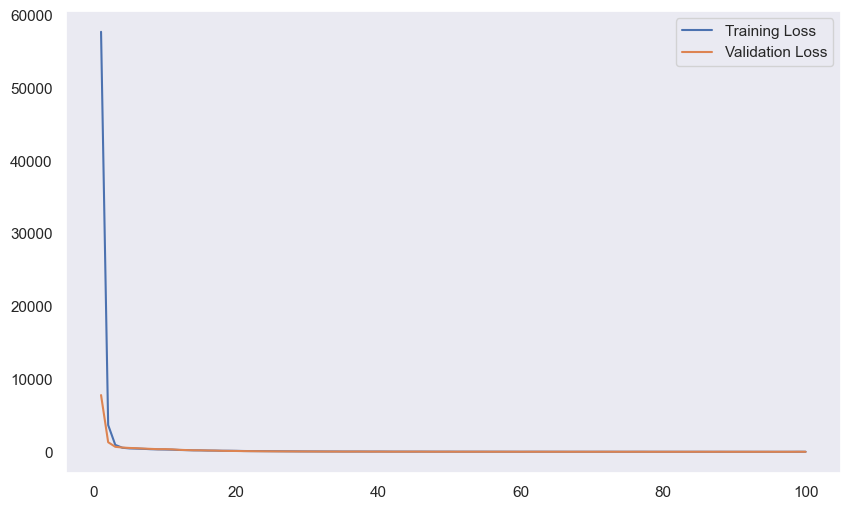

In [130]:
epoch_iter = np.arange(1, epoch + 1)
plt.plot(epoch_iter, loss_per_epoch, label = "Training Loss")
plt.plot(epoch_iter, val_loss_per_epoch_list, label = "Validation Loss")
plt.legend()
plt.grid()
plt.show()

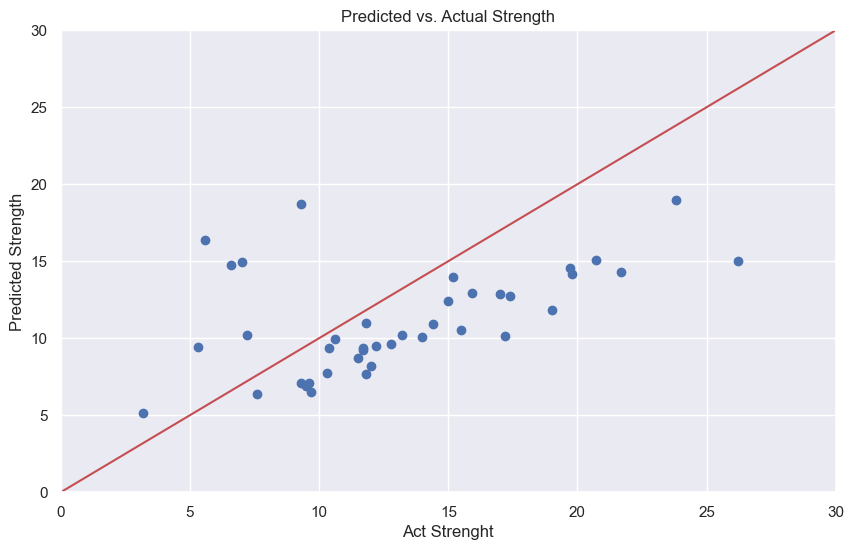

In [131]:
prediction = model(test_X)
error = loss(prediction, test_y)

plt.scatter(test_y, prediction.detach().numpy())

plt.title('Predicted vs. Actual Strength')
plt.xlabel('Act Strenght')
plt.ylabel('Predicted Strength')

diag = [0, 30]
plt.xlim(diag)
plt.ylim(diag)
_ = plt.plot(diag, diag, c='r')

In [132]:
print('Training Loss:: ', error.item())

Training Loss::  41.829586029052734


In [135]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6008 (pid 9116), started 0:00:13 ago. (Use '!kill 9116' to kill it.)